In [1]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter

In [2]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats

from collections import OrderedDict

axis_sz= 14
tick_sz= 14

In [30]:
# converts O2 to micromoles/L 
# calculates PO4* with region specific O2/PO4 value if available, otherwise uses average O2/PO4

def ox_po4_convert(dataset, **kwargs):
    if max(dataset.cluster_d['oxygen'])<300:
        ox_convert = lambda x: x*44.661
        dataset.cluster_d['oxygen'] = ox_convert(dataset.cluster_d['oxygen'])
    
    # O2/PO4 ratios specific to region 
    OP = {'SAtl':184, 'NNAtl':177, 'NAtl':177, 'SO_CDW':180, 'SO_shelf': 183}
    po4_convert = lambda x,y: x + y/175 #175 is O2/PO4 value used in Broecker et al 2018
    if 'corrected_OP' in kwargs:
        po4_star_c = []
        po4_convert_corr = lambda x,y,z: x + y/OP[z]
        for ik in range(len(dataset.cluster_d['latitude'])):
            if dataset.cluster_d['labels'][ik] in OP:
                po4_star_c.append(po4_convert_corr(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik], dataset.cluster_d['labels'][ik]))
            else:
                po4_star_c.append(po4_convert(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik]))
        dataset.cluster_d['po4_star_c'] = np.asarray(po4_star_c, dtype=float)
    dataset.cluster_d['po4_star'] = po4_convert(dataset.cluster_d['phosphate'], dataset.cluster_d['oxygen'])
    return dataset

In [4]:
# labels data points based on latitude; assumes Atlantic basin
def label_lat_ranges(dataset):
    lat_range_d = {(90,50):'NNAtl',(50,20):'NAtl', (20, -50):'SAtl', (-50, -70):'SO_CDW', (-70,-90):'SO_shelf'}
    labels = []
    
    for lat in dataset.cluster_d['latitude']:
        for key in lat_range_d:
            if lat<=key[0] and lat>key[1]:
                labels.append(lat_range_d[key])
    dataset.cluster_d['labels']= labels
    
    return dataset

## Background

### Watermass fraction
When water in the high latiude Atlantic sinks to the deep ocean in the north as North Atlantic Deep Water or in the south as Antarctic Bottom Water, heat and CO<sub>2</sub> are transported from the atmosphere into the ocean interior.  Variation in the ratio of northern sourced to southern sourced water affect the efficacy of the ocean as a sink, so the relative contributions of these two watermasses is a topic of active research for climate scientists and oceanographers.  

### Observed Tracers and the World Ocean Atlas
As processes occur in the ocean, the concentration of chemical constituents change. For example, evaporation results in increased salinity, and cell building by organisms takes up dissolved phosphate from the surrounding water, driving down the phosphate concentration.  Salinity, and phosphate, in addition to nitrate, oxygen, and temperature, among many others, are referred to as "tracers" because when plotted, they help oceanographers "trace" the paths of water and approximate the processes occurring in the ocean. A tracer concentration determined at the ocean surface at water formation and distributed strictly by ocean circulation and mixing (viz. is unaffected by any additional biogeochemical processes), is considered “conservative.” Salinity, as well as certain chloroflorocarbons (CFSs) present in the atmosphere that dissolve in surface water, are examples of conservative tracers. 

#### The dataset: World Ocean Atlas 2013
The World Ocean Atlas 2013 is an ocean data product produced by the Ocean Climate Laboratory and the National Oceanographic Data Center.  WOA fields include temperature, salinity, phosphate, nitrate, oxygen, silicic acid, among others and are reported at 1 degree resolution at 102 standard depth levels from surface to the abyssal floor (5500m).

For the purpose of this investigation, the global ocean has been constrained to minimize the number of locations included that are heavily influenced by local coastal dynamics that do not have significance in global circulation patterns.

### PO<sub>4</sub>\*

The concentration of phosphate (occasionally referred to below by its chemical formula, PO<sub>4</sub>) in the deep ocean reflects a combination of the amount of phsophate present in the water at the time of formation, and the amount contributed by regenerated organic matter--phytoplankton that have died, sunk to some depth, and dissolved into constituent molecules.  In 1998, Broecker et al. published a paper suggesting that by correcting phosphate for non-conservative contribution of phosphate by decomposing organic matter, phosphate could be treated as a conservative tracer, "phosphate\*", and to trace the relative contributions of different watermasses at a given location.

The formula for phosphate*:  
PO<sub>4</sub>\* =PO<sub>4</sub> + O<sub>2</sub>/175   

where 175 is the global average moles of oxygen per molecule phosphate needed to respire decaying phytoplankton.  


In [5]:
def concat(dataset1, dataset2):
    for key in dataset1.cluster_d.keys():
        dataset1.cluster_d[key] = np.concatenate((dataset1.cluster_d[key], dataset2.cluster_d[key]))
    dataset1._x = dataset1.cluster_d['longitude']
    dataset1._y = dataset1.cluster_d['latitude']     
    dataset1._d = dataset1.cluster_d['depth']                                            
    return dataset1

In [18]:
tracers_psql = ['phosphate', 'oxygen', 'nitrate', 'salinity']
tracer_string = ','.join(tracers_psql)

In [20]:
dataset_Atl = dataFetcher()
dataset_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < 0 and longitude >-70 and latitude> -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_Atl= ox_po4_convert(label_lat_ranges(dataset_Atl), corrected_OP= True)
df_Atl = pd.DataFrame(dataset_Atl.cluster_d)


In [22]:
dataset_SO = dataFetcher()
dataset_SO.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_SO= ox_po4_convert(label_lat_ranges(dataset_SO), corrected_OP= True)
df_SO = pd.DataFrame(dataset_SO.cluster_d)


In [23]:
# specifies the ocean in parts that are representative of the global ocean and exclude anamolous riverine inputs etc.
# key: ([min_lon, max_lon], [min_lat, max_lat])
ocean_parts = {'NNAtl':([-70,10],[60,90]),
               'NAtl': ([-70, -10],[60,0]),
               'SAtl': ([-70,20],[-50,0]),
               'Ind': ([20,90],[-50,10]),
               'Aus': ([90,150],[-50, -10]),
               'NPac_E': ([-180,-100],[0, 50]),
               'NPac_W': ([140, 180],[0, 50]),
               'SPac_E': ([-180, -70],[-50, 0]),
               'SPac_W': ([150, 180],[-50, 0])
                    }

In [24]:
# Global Ocean
dataset_globe = dataFetcher()
dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')

for key in ocean_parts.keys():
    ([min_lon, max_lon], [min_lat, max_lat]) = ocean_parts[key]
    dataset_new = dataFetcher()
    dataset_new.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude <{} and latitude> {} and depth >=3000'.format(tracer_string, max_lon, min_lon, max_lat, min_lat),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
    dataset_globe = concat(dataset_globe, dataset_new)

dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [25]:
df_all = pd.concat([df_Atl,df_SO, df_globe])

Unlike nitrate and oxygen, the concentration of phosphate is not affected by processes other than uptake by organisms and regeneration of said organisms post mortem.  The scatter plots suggest that phosphate has the tightest relationship to salinity (a conservative tracer) and that once corrected, phosphate* plotted against salinity forms a reasonable mixing line capped by end-members (maximum and minimum values) located at water formation sites (labelled SO-CDW and NAtl).

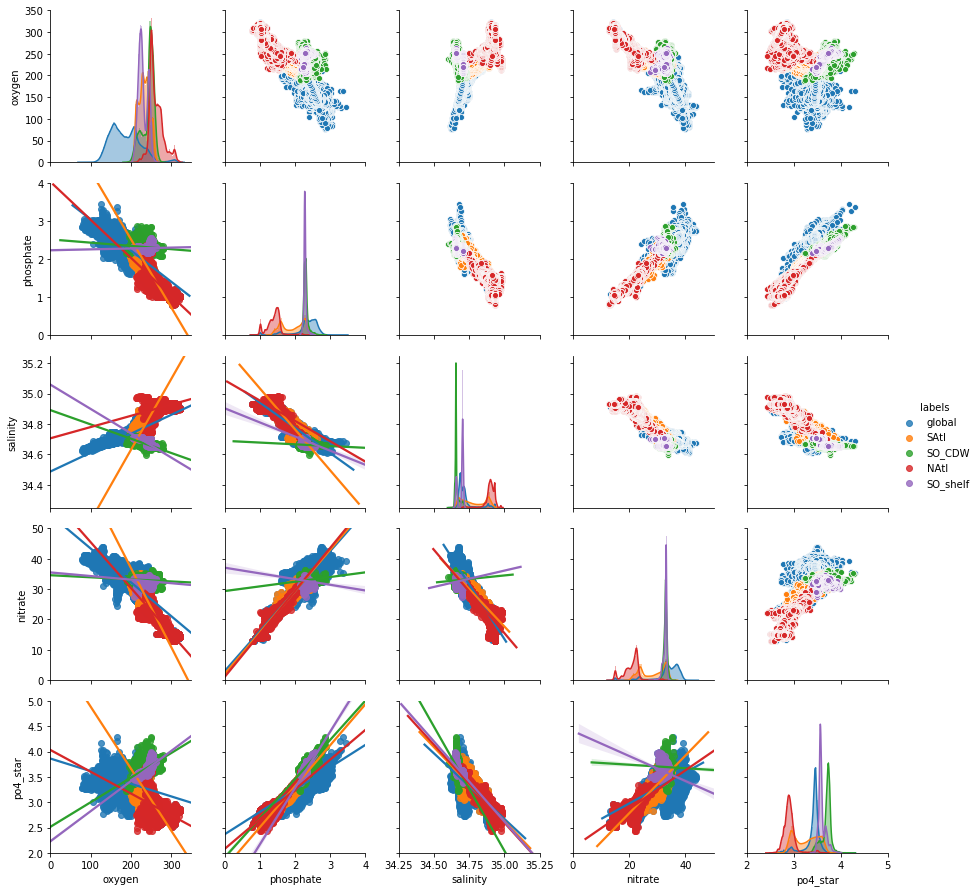

In [28]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate','po4_star', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)
from collections import OrderedDict
d = OrderedDict([('oxygen',(0,350)), ('phosphate',(0,4)), ('salinity', (34.25,35.25)), ('nitrate', (0, 50)),('po4_star',(2, 5))])
for ik, (key, value) in enumerate(d.items()):
    g.axes[0,ik].set_xlim(value[0],value[1])
    g.axes[ik,0].set_ylim(value[0],value[1])

g.add_legend()

Implicit in phosphate* is the assumption that phytoplankton have roughly the same composition and therefore that one might expect the oxygen to phosphate ratio (oxygen consumed during decay of organic matter) to be similarly predictable. Indeed, looking at the regression lines in the phosphate-nitrate plot, the similarity of the slopes for the Atlantic and global oceans suggest that this is a fair simplification.  


In [225]:
# High Latitude Atlantic
dataset_high_lat_Atl = dataFetcher()
dataset_high_lat_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE (longitude < 0 and longitude >-70) and (latitude >50 or latitude <-45) and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_high_lat_Atl= ox_po4_convert(dataset_high_lat_Atl)


High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)


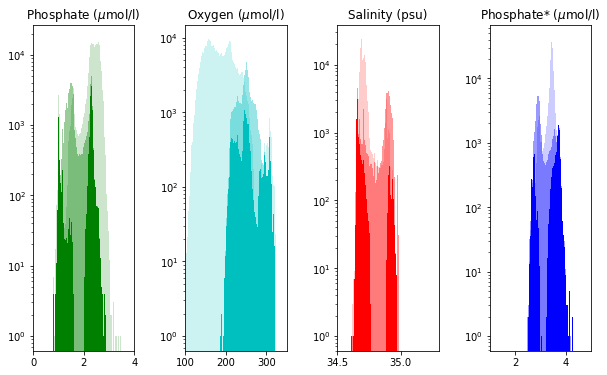

In [227]:
print('High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)')
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [0, 4], 'g'],
          'oxygen': ['Oxygen ($\mu$mol/l)', [100, 350], 'c'],
          'salinity': ['Salinity (psu)', [34.5, 35.3], 'r'],
          'po4_star': ['Phosphate* ($\mu$mol/l)', [1, 5], 'b']}

fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(1,len(tracers), width_ratios=np.ones(len(tracers)), wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    n, bins, patches = ax_out[ik].hist(dataset_globe.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .2)
    n, bins, patches = ax_out[ik].hist(dataset_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .4)
    n, bins, patches = ax_out[ik].hist(dataset_high_lat_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = 1)
    ax_out[ik].set_xlim(tracers[tracer][1])
    ax_out[ik].set_title(tracers[tracer][0])
    plt.yscale('log', nonposy='clip')

The above histograms give a clearer view of how the ranges of phosphate and oxygen extend beyond the values of the high latitude Atlantic, while phosphate* and salinity do a fairly good job bounding their respective global distributions, making them appropriate for watermass fraction calculations. 

## Problem

Phosphate* is conceptually pleasing, but a recent paper by Rae and Broecker (2018) attempted to calculate the ratio of Southern Ocean to North Atlantic Deep Water in the Pacific based on phosphate* and came up short when they compared their calculations to the numbers necessary to satisfy the salinity budget of the deep Pacific.  

## Hypothesis

While the assumption of a constant oxygen to phosphate ratio embedded in the phosphate\* calculation is convenient, there is a body of research that suggests that there may be regional variation in phytoplankton molecular composition and also in the oxygen to phosphate ratio.

I hypothesize that specifying the oxygen to phosphate ratio by region will improve the watermass fraction estimates calculated using phosphate* and bring them more in line with those calculated using salinity. 

## Plan 
I propose to compare the fraction of southern sourced water calculated from salinity to that calculated using phosphate\* at a given depth from the same ten degree section of constant latitude using a paired t-test, for a range of latitudes. I then propose to repeat the calculation with the corrected phosphate\* and plot the two sets of p-values relative to latitude for a range of depths of the deep ocean.   

As a test case, I have applied this approach to the line 30W (longitude range: 35W to 25W) at 2500m and 3000m. See below.

In [31]:
line_lon = -30
min_lat, max_lat = -80, 80

tracers_psql = ['salinity', 'phosphate', 'oxygen']
tracer_string = ','.join(tracers_psql)

datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers_psql)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )
    
min_lon, max_lon = -35, -25
latitudes = [x+.5 for x in range(-70, 55)]
depths = [x for x in range(2500, 3500, 500)]


# tracers = ['salinity', 'po4_star', 'po4_star_c', 'phosphate', 'oxygen']
d = OrderedDict([('salinity', (34.25,35.25)),('po4_star',(2, 5)), ('po4_star_c',(2, 5))])# ('oxygen',(0,350)), ('phosphate',(0,4)), 
tracers = d.keys()
mixing_ratios = {dpth:{} for dpth in depths}
df_mixing_ratios = pd.DataFrame({'lat':[], 'lon':[], 'depth':[], 'mixing_fraction':[], 'tracer': [], 'value':[], 'labels':[]})

def updated_df(df, dataset, mix_rat, trcr):
    df_new = pd.DataFrame({ 'lat':dataset.cluster_d['latitude'], 
                            'lon': dataset.cluster_d['longitude'],
                            'value':dataset.cluster_d[trcr],
                            'depth':dataset.cluster_d['depth'], 
                            'tracer' : [trcr for ik in range(len( dataset.cluster_d[trcr]))],
                            'mixing_fraction': mix_rat,
                            'labels': dataset.cluster_d['labels']})
    df = pd.concat([df, df_new])
    return df
                           
for dpth in depths:
    print(dpth)
    tracer_endmem = {}
    for trcr in tracers:
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        tracer_endmem[trcr]= {'n_char':Atl.n_char, 's_char':Atl.s_char, 'n_char_lat': Atl.n_char_lat, 's_char_lat':Atl.s_char_lat}
        print('\t Tracer:', trcr, '\n\t', tracer_endmem[trcr]['n_char_lat'],':', tracer_endmem[trcr]['n_char'], '\n\t', tracer_endmem[trcr]['s_char_lat'],':', tracer_endmem[trcr]['s_char'])
    for lat in latitudes:
        mixing_ratios[dpth][lat] ={tracer:[] for tracer in tracers}
        dataset_lonslice = dataFetcher()
        dataset_lonslice.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude= {} and depth ={}'.format(tracer_string, max_lon, min_lon, lat, dpth),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
        dataset_lonslice= ox_po4_convert(label_lat_ranges(dataset_lonslice), corrected_OP= True)
        for trcr in tracers:
            for ik in range(len(dataset_lonslice.cluster_d[trcr])):
                obs = dataset_lonslice.cluster_d[trcr][ik]
                mixing_ratios[dpth][lat][trcr].append(max(min((obs-tracer_endmem[trcr]['n_char'])/(tracer_endmem[trcr]['s_char']-tracer_endmem[trcr]['n_char']), 1), 0))
            df_mixing_ratios = updated_df(df_mixing_ratios,dataset_lonslice, mixing_ratios[dpth][lat][trcr], trcr )


2500
	 Tracer: salinity 
	 26.5 : 34.98742575 
	 -59.5 : 34.6537666667
	 Tracer: po4_star 
	 32.5 : 2.64857186229 
	 -60.5 : 3.74242008495
	 Tracer: po4_star_c 
	 32.5 : 2.63192754746 
	 -60.5 : 3.70374082333
3000
	 Tracer: salinity 
	 54.5 : 34.9612996667 
	 -52.5 : 34.659167
	 Tracer: po4_star 
	 31.5 : 2.65884979371 
	 -67.5 : 3.73543562329
	 Tracer: po4_star_c 
	 31.5 : 2.6423746548 
	 -67.5 : 3.69687421708


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


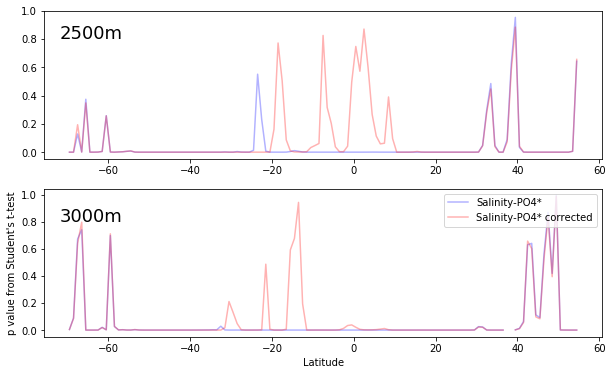

In [33]:
fig ,ax = plt.subplots(nrows=len(depths), ncols=1, figsize = (10,6))
pval_d = {dpth: {'po4_star':[], 'po4_star_c':[]} for dpth in depths}
for ik, dpth in enumerate(depths):
    for lat in latitudes:
        tval,pval=stats.ttest_ind(mixing_ratios[dpth][lat]['salinity'], mixing_ratios[dpth][lat]['po4_star'])
        pval_d[dpth]['po4_star'].append(pval)
        tval,pval=stats.ttest_ind(mixing_ratios[dpth][lat]['salinity'], mixing_ratios[dpth][lat]['po4_star_c'])
        pval_d[dpth]['po4_star_c'].append(pval)
    ax[ik].plot(latitudes, pval_d[dpth]['po4_star'], c= 'b', alpha = .3, label = 'Salinity-PO4*')
    ax[ik].plot(latitudes, pval_d[dpth]['po4_star_c'], c= 'r', alpha = .3, label = 'Salinity-PO4* corrected')
    ax[ik].text(-72,.8,str(dpth)+'m', fontsize = 18)
    
ax[1].set_ylabel('p value from Student\'s t-test')
ax[len(depths)-1].legend(loc =1)
ax[len(depths)-1].set_xlabel('Latitude')


This figure shows the p-values generated from Student's t-tests comparing salinity to phosphate* (blue) and comparing salinity to regionally corrected phosphate* (red) for each latitude along 25W and 2500m and 3000m. For the most part, the corrected phosphate* formula performed as well or better than the original phophate*, indicating that there is heterogenity in the oxygen:phosphate ratio.

This initial work at selected depths suggests that this calculation is sensitive to the oxygen to phosphate ratio chosen.  Indeed preliminary investigation suggests that the effectiveness of the correction is very sensitive to the value specified and where it is applied.  There are published values available for neither the very high latitude North Atlantic, nor the Southern Ocean, but the mixing fraction is sensitive to both these endmember values as well as the corrections applied to various regions of the basin. Fully characterizing the usefulness of this correction would include testing the effect of adding other regions beyond those included here. 

### Diving further into the data with clustering
Another possible avenue of analysis might be clustering the mixing fraction data by dominant watermass (greater or less than 50% southern sourced water) and then breaking it down by watermass label.  For example, such analysis makes the relationship between a the average fraction and standard deviation at a given depth with a given label more explicit.  A large standard deviation might point to an opportunity to split the areas into two swaths with two seperate corrections. 

In [34]:
df_mixing_ratios[df_mixing_ratios.mixing_fraction>.5].groupby(['depth', 'labels', 'tracer'])['mixing_fraction', 'lat'].describe()

mixing_fraction                                \
                                   count      mean       std       min   
depth  labels tracer                                                     
2500.0 SAtl   po4_star              47.0  0.613729  0.067093  0.505283   
              po4_star_c            39.0  0.607920  0.056156  0.512430   
              salinity              84.0  0.655154  0.098179  0.501181   
       SO_CDW po4_star             187.0  0.906855  0.077705  0.727448   
              po4_star_c           187.0  0.906672  0.077939  0.726214   
              salinity             187.0  0.956430  0.039070  0.841951   
3000.0 SAtl   po4_star              83.0  0.655424  0.093974  0.500794   
              po4_star_c            74.0  0.646458  0.085704  0.502728   
              salinity             105.0  0.701762  0.106777  0.502421   
       SO_CDW po4_star             169.0  0.935798  0.065215  0.717946   
              po4_star_c           169.0  0.935418  0.065346  0.716315   
              salinity             169.0  0.981383  0.027793  0.889671   

                                                                    lat  \
                               25%       50%       75%       max  count   
depth  labels tracer                                                      
2500.0 SAtl   po4_star    0.560329  0.611663  0.665710  0.727493   47.0   
              po4_star_c  0.569385  0.620630  0.656363  0.704030   39.0   
              salinity    0.568247  0.643848  0.731137  0.817073   84.0   
       SO_CDW po4_star    0.846837  0.942089  0.974524  1.000000  187.0   
              po4_star_c  0.846684  0.941126  0.974481  1.000000  187.0   
              salinity    0.939806  0.978918  0.980416  1.000000  187.0   
3000.0 SAtl   po4_star    0.571257  0.651925  0.743238  0.833069   83.0   
              po4_star_c  0.569219  0.660738  0.720111  0.809133   74.0   
              salinity    0.619263  0.701015  0.795673  0.866830  105.0   
       SO_CDW po4_star    0.899250  0.960025  0.987290  1.000000  169.0   
              po4_star_c  0.899267  0.959372  0.986948  1.000000  169.0   
              salinity    0.982346  0.994592  0.997571  1.000000  169.0   

                                                                             
                               mean       std   min   25%   50%   75%   max  
depth  labels tracer                                                         
2500.0 SAtl   po4_star   -47.627660  1.377096 -49.5 -48.5 -47.5 -46.5 -45.5  
              po4_star_c -48.038462  1.120295 -49.5 -49.0 -48.5 -47.5 -46.5  
              salinity   -45.785714  2.447381 -49.5 -47.5 -45.5 -43.5 -41.5  
       SO_CDW po4_star   -60.120321  5.938775 -69.5 -65.5 -60.5 -54.5 -50.5  
              po4_star_c -60.120321  5.938775 -69.5 -65.5 -60.5 -54.5 -50.5  
              salinity   -60.120321  5.938775 -69.5 -65.5 -60.5 -54.5 -50.5  
3000.0 SAtl   po4_star   -45.777108  2.519743 -49.5 -47.5 -45.5 -43.5 -40.5  
              po4_star_c -46.229730  2.253140 -49.5 -48.5 -46.5 -44.5 -41.5  
              salinity   -44.738095  3.052502 -49.5 -47.5 -44.5 -42.5 -39.5  
       SO_CDW po4_star   -60.328402  6.117901 -69.5 -65.5 -61.5 -54.5 -50.5  
              po4_star_c -60.328402  6.117901 -69.5 -65.5 -61.5 -54.5 -50.5  
              salinity   -60.328402  6.117901 -69.5 -65.5 -61.5 -54.5 -50.5

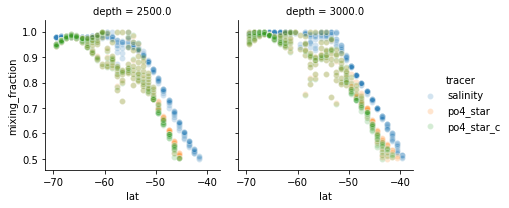

In [25]:
g = sns.FacetGrid(df_mixing_ratios[(df_mixing_ratios.mixing_fraction>.5)], hue = 'tracer', col="depth")
g = g.map(plt.scatter, "lat", "mixing_fraction", edgecolor="w", alpha = .2)
g.add_legend()

In [36]:
# samples with less than 50% southern ocean sourced water
df_mixing_ratios[df_mixing_ratios.mixing_fraction<.5].groupby(['depth', 'labels','tracer'])['mixing_fraction'].describe()

count      mean       std       min       25%  \
depth  labels tracer                                                      
2500.0 NAtl   po4_star    266.0  0.124448  0.053716  0.000000  0.094832   
              po4_star_c  266.0  0.126630  0.055187  0.000000  0.095632   
              salinity    266.0  0.072971  0.061872  0.000000  0.015436   
       NNAtl  po4_star     48.0  0.075242  0.010386  0.046085  0.067007   
              po4_star_c   48.0  0.075377  0.010597  0.045619  0.066982   
              salinity     48.0  0.111462  0.029179  0.027048  0.094336   
       SAtl   po4_star    643.0  0.217818  0.063671  0.117566  0.176431   
              po4_star_c  651.0  0.177113  0.075601  0.075059  0.130433   
              salinity    606.0  0.199958  0.099695  0.060019  0.134643   
3000.0 NAtl   po4_star    237.0  0.147049  0.060663  0.000000  0.094204   
              po4_star_c  237.0  0.149805  0.062375  0.000000  0.095563   
              salinity    237.0  0.067265  0.018189  0.033090  0.051966   
       NNAtl  po4_star     40.0  0.077761  0.009174  0.049799  0.073402   
              po4_star_c   40.0  0.078053  0.009283  0.049662  0.073639   
              salinity     40.0  0.033196  0.022538  0.000000  0.015557   
       SAtl   po4_star    602.0  0.223911  0.061431  0.059605  0.191407   
              po4_star_c  611.0  0.182178  0.074080  0.012590  0.144040   
              salinity    580.0  0.163026  0.077682  0.066854  0.126764   

                               50%       75%       max  
depth  labels tracer                                    
2500.0 NAtl   po4_star    0.111659  0.171354  0.229051  
              po4_star_c  0.113111  0.175291  0.234201  
              salinity    0.048633  0.143262  0.177207  
       NNAtl  po4_star    0.076265  0.083584  0.093404  
              po4_star_c  0.076394  0.083931  0.093970  
              salinity    0.118312  0.133518  0.148729  
       SAtl   po4_star    0.203470  0.231855  0.493175  
              po4_star_c  0.157369  0.189123  0.494718  
              salinity    0.167913  0.211219  0.498793  
3000.0 NAtl   po4_star    0.151084  0.199064  0.248101  
              po4_star_c  0.153847  0.203474  0.253489  
              salinity    0.067850  0.077776  0.112205  
       NNAtl  po4_star    0.078145  0.083468  0.094017  
              po4_star_c  0.078449  0.083919  0.094397  
              salinity    0.028793  0.053612  0.072811  
       SAtl   po4_star    0.210720  0.235302  0.490312  
              po4_star_c  0.163843  0.189302  0.499187  
              salinity    0.141334  0.162589  0.495149

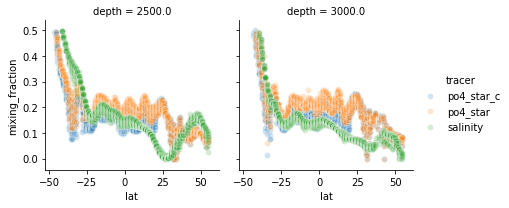

In [37]:
g = sns.FacetGrid(df_mixing_ratios[df_mixing_ratios.mixing_fraction<.5], hue = 'tracer', col="depth")
g = g.map(plt.scatter, "lat", "mixing_fraction", edgecolor="w", alpha = .2)
g.add_legend()

## Reference

/usr/local/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


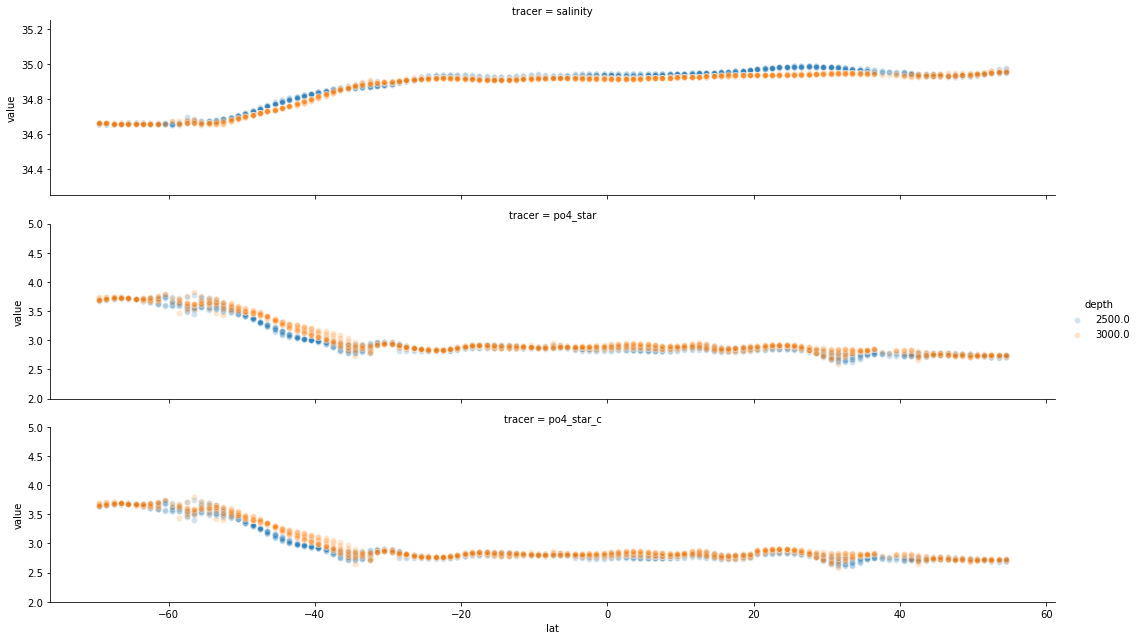

In [32]:
g = sns.FacetGrid(df_mixing_ratios, row = 'tracer', hue="depth",sharey=False, size = 3, aspect = 5)
g = g.map(plt.scatter, "lat", "value", edgecolor="w", alpha = .2)
axes = [ax for ax in g.axes.flat]

for ik, (key, value) in enumerate(d.items()):
    axes[ik].set_ylim([value[0],value[1]])
    
g.add_legend()